<div style="text-align:center">
<h1>Transforming Data</h1>
<h2>7SSG2059 Geocomputation 2016/17</h2>
<h3>_Jon Reades_</h3>
</div>

## This Week’s Overview

This week we're going to explore how visualising data (using pandas and seaborn) helps us to make more sense of our data. We're then going to move on to automating this process because coding isn't _just_ about being able to load lots of data, it's also about being able to be constructively lazy with the data once it's loaded.

## Learning Outcomes

By the end of this practical you should:
- Have created a set of different plots using Seaborn
- Have automated the presentation of data for a number of columns
- Have grasped how a mix of graphs and numbers can help you make sense of your data

## Statistics as Judgement

We hope that you'll go on to make lots of use of what you're learning here, but the single most important thing that you can take away from the remaining weeks of the class is the idea that statistics is not _truth_, it is _judgement_.

[![Are you above average?](http://img.youtube.com/vi/hQLCWHww9OQ/0.jpg)](http://www.youtube.com/watch?v=hQLCWHww9OQ)

### Data as Representation of Reality

The statistician George Box [once said](https://en.wikipedia.org/wiki/All_models_are_wrong) "all models are wrong but some are useful". Now you might think that 'wrong' _necessarily implies_ uselessness, but this aphorism is a lot more interesting than that: let's review the idea of statistics as the study of a '[data-generating process](http://onlinelibrary.wiley.com/doi/10.1111/j.1467-9639.2012.00524.x/full)'. 

The data that we work with is a _representation_ of reality, it is not reality itself. Just because I can say that the height of human beings is normally distributed with a mean of, say, 170cm and standard deviation of 8cm doesn't mean that I've _explained_ that process. What I have done is to say that reality can be reasonably well approximated by a data-generating process that uses the normal distribution. 

Given that understanding of height distributions, I know that someone with a height of 2m is very, very improbable. Not impossible, just highly unlikely. So if I meet someone that tall then that's quite exciting! But my use of a normal distribution to represent the empirical reality of human height doesn't mean that I think our height is _actually_ distributed randomly using a gigantic lottery system: some parts of the world are typically shorter, other parts typically taller; some families are typically shorter, while others are typically taller...

So the _real_ reason for someone's height is to do with, I assume, a mix of genetics and nutrition. However, across large groups of people it's possible to _represent_ the cumulative impact of those individual realities with a simple normal distribution. And using that simplified data-generating process allows me to do things like estimate the likelihood of meeting someone more than 2m tall (which is why I'd be excited to do so, though not as excited as the guy in the next video...).

Here's a (genuinely terrifying) video that tries to explain this whole idea in a different way:

[![From reality to make-believe](http://img.youtube.com/vi/HAfI0g_S9oo/0.jpg)](https://www.youtube.com/watch?v=HAfI0g_S9oo)

In the same way, real individuals earn different incomes for all sorts of reasons: skills, education, negotiation ability... and, of course, systematic discrimination or bias. Because of wide variations in individual lived experience, it's quite hard to _prove_ that any _one_ person has been discriminated against unless you have the 'smoking gun' of an email or other direct evidence that this has happened. 

But if I have data on _many_ men and women (from a company, industry, or society) to work with, then I can take a look at what data-generting processes best describe what I've observed. And I can also create a data generating process that would describe what I'd _expect_ to see if no systematic discrimination were taking place at all. I make that sound simple but, of course, it's really hard to do this properly: do you account for the fact that discrimination has probably happened throughout someone's lifetime, not just in their most recent job? And so on.

### What is _Significant_?

But, when we have created a data-generating process that captures this at what we feel is an appropriate level, then the analytical process becomes about testing to see if there is a _significant_ difference between what I expected and what I observed. Once we've done that, then we can start to rule out claims that 'there are no good candidates' and the other defences of the indefensible. It is always theoretically _possible_ that a company had trouble finding qualified candidates, but as you put together the evidence from your model it may well  become increasingly _improbable_.

So, always remember that, while the data is not reality, it _is_ a very useful abstraction of reality that allows us to make certain claims about what we expected to see. Linking our observations to what we know about the characteristics of the data generating process then allows us to look at the _significance_ of our results or to search for outliers in the data that seem highly improbable and, consequently, worth further investigation.

In [1]:
import matplotlib as mpl
mpl.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt

In [35]:
import pysal as ps
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.cm as cm
import urllib
import zipfile
import re
import os

import random
random.seed(20171107)
np.random.seed(20171107)

def dld_merge_gsa_data(dst='merged.csv.gz'):
    """
    Function to automatically build the merged LSOA and air quality data set.
    
    Keyword arguments:
    dst -- a local path to use as a destination (default merged.csv.gz)
    """
    dst_compression='gzip'
    
    # Check if local copy exists...
    if os.path.exists(dst):
        # Yes, then just read and return the data frame
        print("File already downloaded.")
        # The 'low memory' option means pandas doesn't guess data types
        df = pd.read_csv(dst, compression=dst_compression, low_memory=False)
        
    else:
        # No, then download and save a local copy
        print("Downloading remote data...")
        
        # It is possible to have a remote file with no
        # compression so this is just a piece of forward
        # looking code....
        df1 = pd.read_csv(
            'https://github.com/kingsgeocomp/geocomputation/blob/master/data/LSOA_AirQuality.csv.gz?raw=true',
            compression='gzip', low_memory=False
        ) # The 'low memory' option means pandas doesn't guess data types
        df2 = pd.read_csv(
            'https://github.com/kingsgeocomp/geocomputation/blob/master/data/LSOA%20Data.csv.gz?raw=true',
            compression='gzip', low_memory=False
        )
        df = pd.merge(df1, df2, how='left', on='LSOA11CD')
        # And save it
        print("Writing to local file...")
        df.to_csv(dst, compression=dst_compression, index=False)
    print("Done.")
    return df

In [36]:
df = dld_merge_gsa_data()
df.set_index(['LSOA11CD'], drop=True, inplace=True)

File already downloaded.
Done.


----

# Transformation

Transformations are useful when a data series has features that make comparisons or analysis difficult, or that affect our ability to intuit meaningful difference. By manipulating the data using one or more mathematical operations we can sometimes make it more *tractable* for subsequent analysis. In other words, it's all about the _context_ of our data.

[![How tall is tall?](http://img.youtube.com/vi/-VjcCr4uM6w/0.jpg)](http://www.youtube.com/watch?v=-VjcCr4uM6w)

### Working with Demonstration Data

Here's an example from one of our earlier lessons, but now written as Python code: let's say that we want to understand how student heights (and the visiting Mr. G.) are distributed within a class. It's not at all easy if all you have to go on is a list of raw heights: 160cm, 158cm, 150cm, 185cm, 172cm, 175cm, 166cm... and, of course, Mr. Bill Gates himself, to know how big a range you've got on your hands and where people fall relative to the mean.

Let's try writing this out as Python code:
```python
# Create an empty data frame to 
# hold our height data
df2 = pd.DataFrame() 
```
Here we've created an empty data frame – as yet it contains no data.
```python
# Create and add a series
df2['Height'] = pd.Series(
    [160, 158, 150, 185, 172, 175, 166, 168],
    index = ['Judy','Frank', 'Alice', 'Eve', 'Bob', 'Carlos', 'Dan', 'Bill G.']
)
```
Then we create a new data series: the data for the series is the heights, the index is the name of the student. We assign this new data series to 'Heights' in the data frame.
```python
# Look at the results
df2.describe()
```
And, as always, a good next step is to check that you got what you expected.

In [4]:
df2 = pd.DataFrame() 

# Create and add a series
df2['Height'] = pd.Series(
    [160, 158, 150, 185, 172, 175, 166, 168],
    index = ['Judy','Frank', 'Alice', 'Eve', 'Bob', 'Carlos', 'Dan', 'Bill G.']
)

# Look at the results
df2.describe()

,Height
count,8
mean,167
std,11
min,150
25%,160
50%,167
75%,173
max,185


Now let's add their wealth...

In [5]:
df2['Wealth'] = pd.Series([28300, 21258, 37234, 32748, 18536, 75093, 124382, 5124398742348], index=df2.index)

# Check the results
df2.describe()

,Height,Wealth
count,8,8
mean,167,"640,549,884,987"
std,11,"1,811,748,533,060"
min,150,"18,536"
25%,160,"26,540"
50%,167,"34,991"
75%,173,"87,415"
max,185,"5,124,398,742,348"


An obvious first step to understanding this student data would be to use the mean ($\mu$) from the data since that tells us the _average_ height and wealth of all students in the class. But wouldn't it be even _more_ interesting to be able to look at how tall students are _relative_ to the mean? Is there someone from the basketball team taking this course? Or maybe the cox from a crew? How could we make it easy to compare the difference between each student and the overall class average in order to spot these 'special cases'?

In many cases, the best way to make this comparison is to _subtract the mean_. Why is that? What does it achieve?

Let's think it out:
1. If a student is shorter _than average_ then their transformed height is less than 0
2. If a student is taller _than average_ then their transformed height is more than 0
3. The distance from 0 (e.g. -20 vs -3) gives us _some_ sense of how short or how tall someone is relative to that mean

In a mathematical form we'd write this transformation as:
$$
x - \mu
$$

In pandas we can express this transformation as:
```python
df['<new column name>'] = df.<column>-df.<column>.mean())
df.describe()
```

We can break this apart as:

* `df.<column>` – this is the _entire_ data series
* `df.<column>.mean()` – this calculates the mean ($\mu$) of the data series
* We perform this calculation and then use the results to create a new data series
* We assign this series to a new column in the data frame called `<new column name>`.

Pandas is smart enough to know that it needs to take _each_ student height and then subtract the mean height of all students from that value. So even though it looks like we're performing a single calculation, we're actually performing as many calculations as there are rows in the data frame but without needing to write any tricky code!

To recap: looking at the heights of the students (whether in code or in the notebook generally) it's hard to tell how far each student is from average, and who might be especially (*significantly*) tall or short. When this happens we can _transform_ the raw data in order to make it easier to see and interpret this variation.

*Remember*: subtracting the mean is a linear transformation (unlike the log-transform).

Try the transformation in the coding area below:

In [6]:
df2['TransformedHeights'] = df.???-df.???
df2['TransformedWealth']  = df.???-df.???
df2.describe()

SyntaxError: invalid syntax (<ipython-input-6-5b027f004776>, line 1)

What do the Transformed Heights mean? Does the notation make any sense to you? It may help to remember that Python, like nearly all programming languages, can rack up very, very minute errors when working with floating point numbers.

So the output is in something called scientific notation, where numbers are represented using an exponent for accuracy and consistency in the formatting. To change this, try a Google search on `"python data frame force non-scientific output"`. You should find a solution in the first few results. 

The concept of `lambda` is something we haven't seen before: previously, when we wanted to define a function we _had_ to use `def <function name>:`, but sometimes we just need a tiny snippet of code to do something useful in a function-like way and don't want to have to write a full definition. That's where `labmda` comes in: it is creating something called an *anonymous* function, meaning that we can define a function without giving it a name. Why is this useful? [Read more about lambda](https://pythonconquerstheuniverse.wordpress.com/2011/08/29/lambda_tutorial/).

## Selecting the Right Transformation

Now let’s have a look at our real-world data (or should that be "The Real World"?). We've got quite a few columns to work with, but they describe quite different types of phenomena. Let's see how this plays out in the distributions and, consequently, the types of transformations that area appropriate...

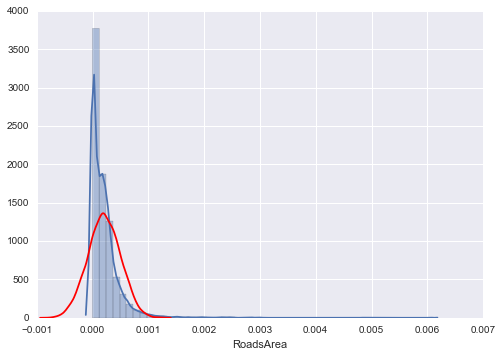

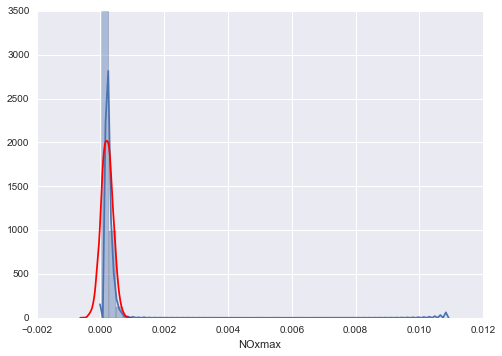

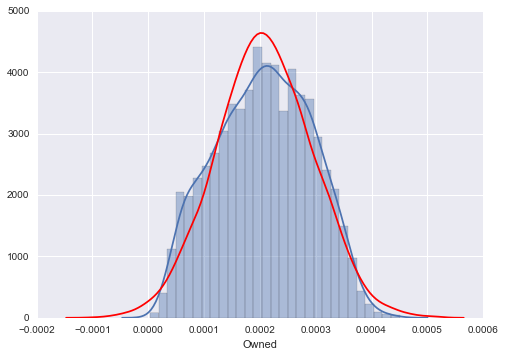

In [17]:
# Add comments to explain what this function
# is doing.
def normal_from_dist(series): 
    mu = series.mean()
    sd = series.std()
    n  = len(series)
    s = np.random.normal(mu, sd, n)
    return s

# Now use the function above to plot both a distribution plot 
# with both histogram and KDE, and then add a _second_ overplot
# distplot to the same fig. The overplot should not have a histogram
# and the color should be red. You should be able to check the 
# last figure (Owned) against the next block of questions to see
# if you got the right answer.
for c in ['RoadsArea','NOxmax','Owned']:
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    sns.distplot(df[c]) #???
    sns.distplot(normal_from_dist(df[c]), hist=False, color='red') #???

**Q1**: For which of the columns are the mean and standard deviation _most_ appropriate as measures of centrality and spread?

**A1**: _Your answer **and rationale** here._

## Making use of a transformation

Let's focus on the 'Owned' (_i.e._ home ownership) column. Without allowing for the fact that different areas have different numbers of households to begin with (we'll get to _that_ later) how do we go about setting a threshold for areas with high concentrations of home ownership? Let's look at the chart again (also a good way to check you got the right code in the block above).

![Ownership Distribution](https://github.com/kingsgeocomp/geocomputation/blob/master/img/Owned.png?raw=true)

We _know_ that the middle is somewhere about 350 (we can get the exact number using `<series>.describe()`) but is 400 extreme? What about 600? Or 500? 

#### The Standard Normal

The standard normal distribution has some useful properties; here's a refresher:

![Standard Normal](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Boxplot_vs_PDF.svg/500px-Boxplot_vs_PDF.svg.png)

The cut-offs that we're usually the most interested in are:

| Confidence Level | z\*-value |
|------------------|-----------|
| 50% | 0.675 |
| 80% | 1.28 |
| 90% | 1.645 (by convention) |
| 95% | 1.96 |
| 98% | 2.33 |
| 99% | 2.58 |
| Outlier | 2.698 | 

What you'll notice is that we can have _any_ cut-off we want. By convention the 95% confidence interval had become the standard for a 'significant' result, but over the past 10-15 years the importance of publications for researchers (and the fact that reviewers were using 95% CIs as an _heuristic_ for determining whether the research had 'succeeded') led the rise of _p-hacking_ (or _p-value hacking_) in which authors basically played with their data until their results surpassed this magical threshold. As the starting example shows, you can say _anything_ with data if you want.

<div style="text-align:center">
<h3>“If you torture the data long enough, it will confess.”</h3>
<h4>― Ronald H. Coase, Essays on Economics and Economists</h4>
</div>

### Using the transformation to select 'outliers'

Using common sense, the 95% CI, and a mix of code we've used above _and_ in earlier weeks:
1. How many LSOAs are _above_ the upper CI?
2. How many LSOAs are _below_ the lower CI?
3. What are the LSOA names for the first three LSOAs just _above_ the upper CI?
4. What are the LSOA names for the first three LSOAs just _below_ the lower CI?
5. Can you plot the extreme values on the same plot?

The output I'm looking for is below, but I'll settle for anything _close_ (_i.e._ you have the right results even if the formatting if off) and I've included some comments and snippets of code to get you started...

There are 62 LSOAs (1.28%) above the upper CI of 591.19
There are 62 LSOAs (1.28%) below the lower CI of 60.81
The upper LSOAs are: Sutton 009A, Richmond upon Thames 011D, Richmond upon Thames 012D
The lower LSOAs are: Kensington and Chelsea 005D, Lambeth 009B, Tower Hamlets 018A


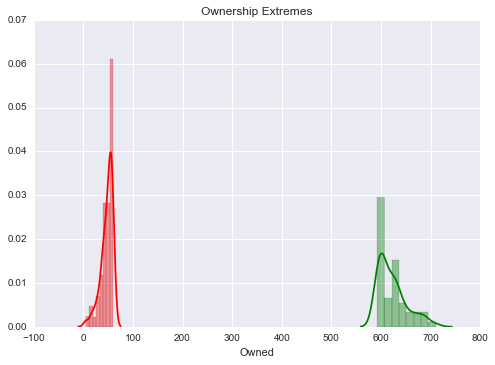

In [8]:
# First, we need the mean and standard deviation of the data
mu = df.Owned.mean() #???
sd = df.Owned.std() #???

# Then we need our upper and lower CIs
uci = mu + 1.96 * sd
lci = mu - 1.96 * sd

# Then we need to select the LSOAs falling above
# and below our CI values (you can sort the results
# at the same time, or do this as a separate command)
udf = df.loc[df.Owned > uci].sort_values(by='Owned', ascending=True) # udf == upper df
ldf = df.loc[df.Owned < lci].sort_values(by='Owned', ascending=False) # ldf == lower df ???

# Output main results
print("There are {0} LSOAs ({1:.2f}%) above the upper CI of {2:.2f}".format(len(udf),(float(len(udf))/len(df))*100,uci))
print("There are {0} LSOAs ({1:.2f}%) below the lower CI of {2:.2f}".format(len(ldf),(float(len(ldf))/len(df))*100,lci))
print("The upper LSOAs are: " + ", ".join(udf.LSOA11NM.head(3).values))
print("The lower LSOAs are: " + ", ".join(ldf.LSOA11NM.head(3).values))

# And plot the results
fig1 = plt.figure()
plt.title("Ownership Extremes")
ax1 = fig1.add_subplot(111)
sns.distplot(udf.Owned, color='green') # ???
sns.distplot(ldf.Owned, color='red') # ???

Here's what I got:
```shell
There are 62 LSOAs (1.28%) above the upper CI of 591.19
There are 62 LSOAs (1.28%) below the lower CI of 60.81
The first three upper LSOAs are: Sutton 009A, Richmond upon Thames 011D, Richmond upon Thames 012D
The first three lower LSOAs are: Kensington and Chelsea 005D, Lambeth 009B, Tower Hamlets 018A
```

![Ownership Extremes](https://github.com/kingsgeocomp/geocomputation/blob/master/img/Owned_Extremes.png?raw=true)

**Q2.** Can you think why we only seem to have 2.56% of the LSOAs falling outside of our 95% CI? Shouldn't it be 5%?

**A2.** _Your answer here_

**Q2 (Bonus Part 1).** Can you think how to get a count of LSOAs by borough for each of the two extreme ends of the distribution? Write your code below. _Hint:_ You want to look at the highest-voted answer on [this page](https://stackoverflow.com/questions/19384532/how-to-count-number-of-rows-in-a-group-in-pandas-group-by-object).

**Q2 (Bonus Part 2).** What do you notice about these upper and lower outliers? Is there a geographical pattern to suggest that this might not be quite what you want?

In [25]:
print("Upper outliers: ")
print(udf[['LAD11NM']].groupby('LAD11NM').size()) # ???
print("\nLower outliers: ")
print(ldf[['LAD11NM']].groupby('LAD11NM').size()) # ???

Upper outliers: 
LAD11NM
Barnet                   2
Bexley                   7
Brent                    1
Bromley                 22
Croydon                  3
Enfield                  2
Harrow                   1
Havering                12
Hillingdon               1
Hounslow                 1
Redbridge                2
Richmond upon Thames     3
Sutton                   3
Waltham Forest           2
dtype: int64

Lower outliers: 
LAD11NM
Barking and Dagenham      1
Brent                     3
Camden                    5
City of London            1
Ealing                    1
Enfield                   1
Greenwich                 4
Hackney                   9
Hammersmith and Fulham    2
Haringey                  3
Islington                 2
Kensington and Chelsea    6
Lambeth                   3
Lewisham                  2
Newham                    2
Southwark                 8
Sutton                    1
Tower Hamlets             4
Westminster               4
dtype: int64


## Logarithmic Transformation

Logarithmic transformations are also considered fairly simple, but they are _non_-linear transformations and so they do change the relationships in your data in important ways. Although you _could_ use any logarithm, the natural log is considered the most useful since both the mean and standard deviation retain _some_ meaning (though you probably wouldn't report these as such). If you don’t remember what a logarithm is try these:

[![From reality to make-believe](http://img.youtube.com/vi/zzu2POfYv0Y/0.jpg)](https://www.youtube.com/watch?v=zzu2POfYv0Y)

[![From reality to make-believe](http://img.youtube.com/vi/akXXXx2ahW0/0.jpg)](https://www.youtube.com/watch?v=akXXXx2ahW0)

[![From reality to make-believe](http://img.youtube.com/vi/0fKBhvDjuy0/0.jpg)](https://www.youtube.com/watch?v=0fKBhvDjuy0)

The last video was made by Ray & Charles Eames, two of the 20th Century’s most famous designers.

**Q3.** Why are log-transforms considered non-linear?

**A3.** _Your answer here_

## Let's imagine...

Let's imagine that:

1. I think that there is relationship between pollution and the presence of major roads.
2. I don't know what kind of relationship there might be.

We're going to start with the simplest approach: a chart!

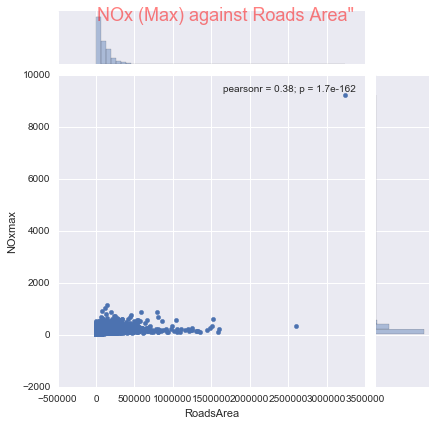

In [9]:
g = sns.jointplot(x=df.RoadsArea, y=df.NOxmax, size=6)
g.fig.suptitle('NOx (Max) against Roads Area"', fontsize=18,color="r",alpha=0.5)

Hmmm, that didn't help very much. It looks like our RoadsArea data is very heavily skewed and that there are a lot of very low values in the data. There also seems to a be at least one major outlier. In this presentation it's really hard to tell if we're getting a strong correlation (0.38) just because of the skew in the data... Perhaps a different transformation might help?

### Logarithmic Transforms in Pandas

To create a new series in the data frame containing the natural log of the original value it’s a similar process to what we've done before, but since pandas doesn't provide a log-transform operator (i.e. you can’t call `df.Owned.log()` ) we need to use the `numpy` package:
```python
series = pd.Series(np.log(df.RoadsArea))
```
Try performing the transformation and then `describe()` the results in the coding area below. Is it more clear to you now why a log-transform is a non-linear transformation?

**_Warning_**: What is the natural log of 0? And of 1? What do you need to change in the code above to make this transformation work? Output below...

count   4,835
mean        9
std         5
min         0
25%         7
50%        11
75%        12
max        15
Name: RoadsArea, dtype: float64


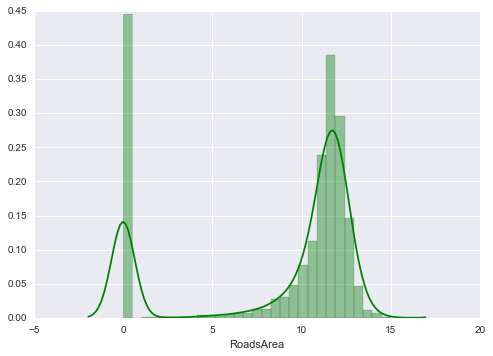

In [10]:
series = pd.Series(np.log(df.RoadsArea+1)) # ???
print(series.describe())
sns.distplot(series, color='green')

```
count   4,835
mean        9
std         5
min         0
25%         7
50%        11
75%        12
max        15
Name: RoadsArea, dtype: float64
```
Now this _is_ interesting: the output of the graph shows what seems to be two quite different things going on in our data! We've obviously got the LSOAs that contain _no_ major roads, but then we've got something else that is _much_ closer to 'normal' (though obviously not properly normal). Technically, this is closer to _log-normal_ and you **should not** think of the mean or standard deviation as being numbers that you would report. What they _can_ do is help you to set a cut-off for the LSOAs that are most impacted by major roads...

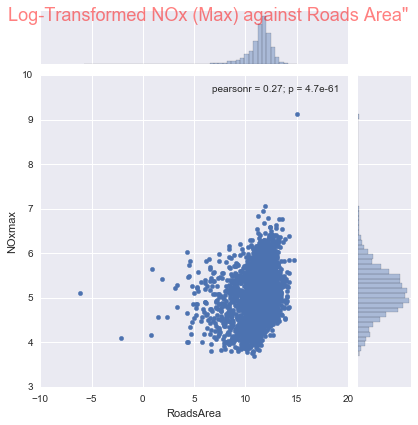

In [11]:
hrds = df.loc[df.RoadsArea >0] # hrds == has (major) roads

g = sns.jointplot(x=np.log(hrds.RoadsArea), y=np.log(hrds.NOxmax), size=6)
g.fig.suptitle('Log-Transformed NOx (Max) against Roads Area"', fontsize=18,color="r",alpha=0.5)

There still isn't a clear answer here, but at this point I would be thinking: there's _something_ going on, but looking at the correlation coefficient (Pearson's r == 0.27 [_stay tuned for Week 9!_]) I wouldn't feel very comfortable that NOx (Max) values were predicted solely by the total area of a LSOA within 250m of major roads... this is what we mean by building a model: we know we've got our hands on something useful, but we also know that we need to work on it some more to make the model _useful_.

## Standardisation

### Proportional Standardisation

Clearly, a proportion (e.g. a percentage) of the total count contained in one LSOA is one way of standardising data since, unless you're measuring change, it limits the range to between 0% and 100%. Programmers and statisticians almost always write a proportion in a decimal format so the range is between 0.0 and 1.0. 

Mathematically, however, the notation is a little more forbidding:
$$
p_{i} = \frac{x}{\sum_{i=1}^{n} x}
$$
However, it's important that you begin to familiarise yourself with the mathematical notation since many papers on computational geography will make use of this form. Let's break it down:

1. It's a fraction: the observation _x_ divided by, errrr, something involving x
2. The numerator is easy
3. The denominator is hard
4. The key is in the $i=1$ and $n$, which tells us that the sum is for 'all i' (i.e. summing for every _x_-value in the data set) 

In other words, we take the `sum()` of the column of `x` as the divisor for *each* observation of `x`. 

To put it in terms of our heights data:

1. Take each person's height (which we call '_x_')
2. Add up (sum: $\sum$) every _x_ (which runs from 1.._n_) in the data set
3. And divide \#1 by \#2

But the point is that that notation applies for every data set, not just our heights data. That's where the mathematical formula is more useful – it's not linked to the specifics of this particular data set.

### Proportional Standardisation in Pandas

We can calculate the proportion for each area using a similar approach to what we've seen before in the Transformation section:
```python
df['proportion'] = df.<column>/df.<column>.sum()
```
You can see the link here between the mathematical notation and the computational representation, right?

Let's do this for the columns that we've been working with and try printing out various summary metrics for the new column and comparing them to the raw values. 

count   4,835.00000
mean        0.00021
std         0.00029
min         0.00000
25%         0.00000
50%         0.00014
75%         0.00028
max         0.00606
Name: RoadsArea, dtype: float64
count   4,835.00000
mean        0.00021
std         0.00019
min         0.00004
25%         0.00013
50%         0.00018
75%         0.00026
max         0.01086
Name: NOxmax, dtype: float64
count   4,835.00000
mean        0.00021
std         0.00009
min         0.00000
25%         0.00014
50%         0.00021
75%         0.00027
max         0.00045
Name: Owned, dtype: float64


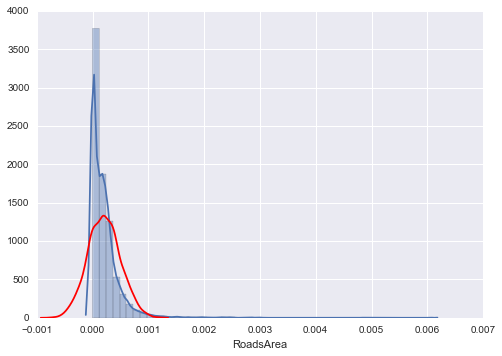

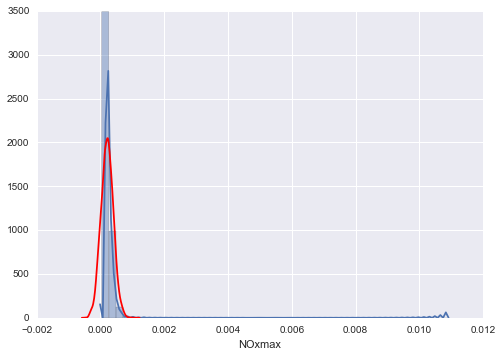

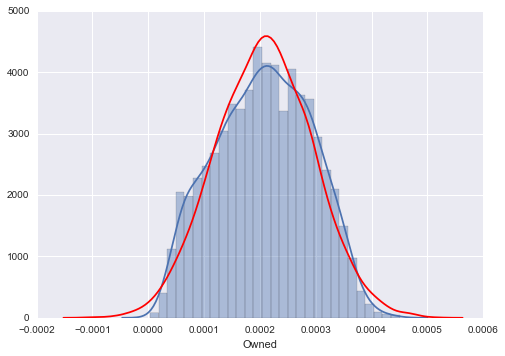

In [26]:
# Why do I do this???
pd.set_option('display.float_format', lambda x: '{:,.5f}'.format(x))

dfs = df.copy() # Copy df to df-standardised

for c in ['RoadsArea','NOxmax','Owned']:
    dfs[c] = df[c]/df[c].sum() # ???
    print(dfs[c].describe())
    
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    sns.distplot(dfs[c]) 
    sns.distplot(normal_from_dist(dfs[c]), hist=False, color='red')

### Think!

In this case are the simple standardisations very useful? Can you think why we might not be _that_ interested in these results? So if that's _not_ what we want, then what _do_ we want? It's worth thinking about what these columns are actually measuring:

1. Roads Area is a measure the area (in m^2) that are near to a major road. What other column contains areal data that might be relevant?
2. Owned is the number of properties that are owned outright. What other column contains information about the total number of potential properties (allowing for some fudging for houses that are owned by one household but shared with others).

### Areal Standardisation

So the most basic and obvious standardisation at this point would be to work out what the 'Roads Area' is _really_ measuring -- we've got a total area near roads but still have no idea how big the actual LSOA _is_. So it's quite possible that an outer borough has a lot of area near major roads, but a low NOx reading overall because it also has a lot of areas that are a _long_ way from major roads and their pollutants.

Try copying the code block above into the block below and adjusting it for the Roads Area data so that it gives you a more useful answer. *Hint*: the right answer in _this particular case_ will have the following output:
```python
count   4,835.0000
mean        0.4224
std         0.3659
min         0.0000
25%         0.0086
50%         0.3935
75%         0.7705
max         1.0000
dtype: float64
```

count   4,835.0000
mean        0.4224
std         0.3659
min         0.0000
25%         0.0086
50%         0.3935
75%         0.7705
max         1.0000
dtype: float64


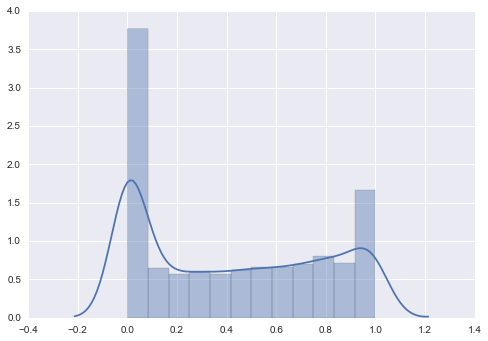

In [38]:
# Why do I do this???
pd.set_option('display.float_format', lambda x: '{:,.4f}'.format(x))

dfs = df.copy()

for c in ['RoadsArea']:
    series = df[c]/df.Area # ???
    print(series.describe())
    
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    sns.distplot(series)
    dfs[c] = series

### Household Standardisation

Let's do the same for the ownership data. Here we wouldn't standardise by area (we've already got a population density measure anyway) but by something else that would give us a sense of the _density of ownership_ in an area...

Here's your hint:
```python
count   4,835.0000
mean        0.4988
std         0.2252
min         0.0095
25%         0.3181
50%         0.4880
75%         0.6689
max         0.9740
dtype: float64
```

In [40]:
df.columns.values

array(['PM25mean', 'PM25min', 'PM25max', 'PM25sd', 'PM10mean', 'PM10min',
       'PM10max', 'PM10sd', 'NOxmean', 'NOxmin', 'NOxmax', 'NOxsd',
       'NO2mean', 'NO2min', 'NO2max', 'NO2sd', 'LSOA11NM', 'MSOA11CD',
       'MSOA11NM', 'LAD11CD', 'LAD11NM', 'RGN11CD', 'RGN11NM', 'USUALRES',
       'HHOLDRES', 'COMESTRES', 'POPDEN', 'HHOLDS', 'AVHHOLDSZ',
       'geometry', 'GreenspaceArea', 'RoadsArea', 'Owned', 'SharedOwnshp',
       'SocialRented', 'PrivateRented', 'RentFree', 'ORroomsM1',
       'ORbedsM1', 'RoomsHH', 'BedsHH', 'White', 'MultiEthnic', 'Asian',
       'Black', 'OtherEthnic', 'MedianIncome', 'SumPrice', 'MeanPrice',
       'MedianPrice', 'EntireHome', 'PrivateRoom', 'SharedRoom',
       'SmallHost', 'MultiHost', 'PropertyCount', 'Area'], dtype=object)

count   4,835.0000
mean        0.4988
std         0.2252
min         0.0095
25%         0.3181
50%         0.4880
75%         0.6689
max         0.9740
dtype: float64


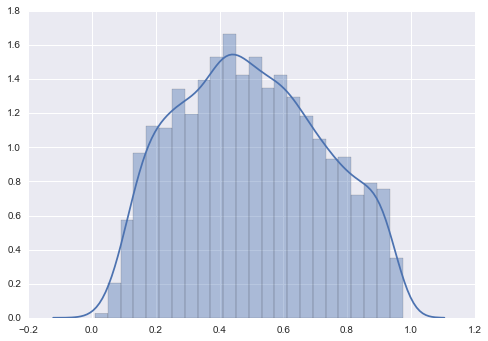

In [41]:
# Why do I do this???
pd.set_option('display.float_format', lambda x: '{:,.4f}'.format(x))

dfs = df.copy() # This would overwrite the one above

for c in ['Owned']:
    series = df[c]/df.HHOLDS # ???
    print(series.describe())
    
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    sns.distplot(series)
    dfs[c] = series

Right, now we know that _nowhere_ has a share of Group 1 residents above about 50% (though that is _high_!), and that most LSOAs in England & Wales have a share that is substantially lower: in the range 0–15%. This already tells us quite a bit about the overall distribution of Group 1 households, but we can go a lot further...

## Z-Score Standardisation

The z-score is a common type of standardisation, but it's a little more complex than a simple proportion; however, both are designed to enable us to compare data across different groups of observations. We can easily compare two percentages to know which one is more, and which less (e.g. I got 80% on one exam and 70% on the other).

But let's think about a slightly different question: 'which exam did I do _better_ on?' What if you got 80% on an exam where everyone else got 85%? Suddenly that doesn't look quite so good right? And what if your 70% was on an exam where the average mark was 50%? Suddenly that looks a lot better, right?

The z-score is designed to help you perform this comparison directly.

As a reminder, the z-score looks like this:
$$
z=(x-\mu)/\sigma
$$

That's: `(<data> - <mean>)/<standard deviation>`

### Z-Score Standardisation in Pandas

Let’s figure out how to translate this into a new columns called `Group1ZStd`!

We’ve already done the first part of this calculation up above in `Group1LessMean`. That series is the same as $x-\mu$, so all we need to do is divide by the standard deviation.

So one way to do this is:
```python
df['Group1ZStd'] = 
     df.Group1LessMean/df.Group1.std()
```
That works exactly the same way as what we did when we subtracted the mean in the first place: we’re just taking the results from the previous equation and passing them on to this one. But now that you've seen how we can 'chain' together method calls, then you should know that we could _also_ do it this way:
```python
df['Group1ZStd'] = 
     (df.Group1 - df.Group1.mean()) / df.Group1.std()
```
Do you see how we can begin to build increasingly complicated equations into the process of creating a new data series?

### Using the Z-Score

Let's start to bring the idea of the 'data generating processes' to life. The first thing to do with the z-score is to look at what it implies:

1. Subtracting the mean implies that the mean _is a useful measure of centrality_: in other words, the only reason to subtract the mean is if the mean is _meaningful_. If you are dealing with highly skewed data then the mean is not going to be very useful and, by implication, neither is the z-score.
2. Dividing by the Standard Deviation implies that this _is a useful measure of distribution_: again, if the data is heavily skewed or follows some exponential distribution then the standard deviation is not going to very useful as an analytical tool.

So the z-score is _most_ relevant when we are dealing with something that look vaguely like a standard normal distribution (which has mean=0 and standard deviation=1). In those cases, anything with a z-score more than 1.96 standard deviations from the mean is in the 5% significance zone. 

But remember: we can't really say _why_ one particular area has a high concentration of well-off individuals or why one individual is over 2m tall. All we are saying is that this standardised value is a pretty unlikely outcome _when compared to our expectation that people are randomly distributed across the region_ or _that people have randomly-distributed heights of mean 'x' and standard deviation 'y'_. 

Of course, we _know_ that people aren't randomly distributed around the country in the same way that we know that height isn't genuinely random becuase of the influence of genetics, nutrition, etc. But we need a way to pick out what counts as _**significant**_ over- or under-concentration (or height) from the wide range of 'a bit more' or 'a bit less' than 'normal'. **_If_** a normal distribution does a good job of representing the overall distribution of heights (_whatever_ the reason) then someone of 2m is highly unlikely but we can't say _how_ unlikely until we've placed them on the distribution.

Let's put it another way:
* Is 10% of wealthy individuals in a small area a high concentration?
* How about 20%?
* 30%?

The only way to answer that question is to use something like the z-score since it standardises all of the values _against the average_. If wealthy people were distributed at random then we would _expect_ that most areas would have about the average concentration. Some areas will have a few more. Some areas a few less. But according to the way that the standard normal distribution works, _nowhere_ should have a z-score of 10. Or 20, since that is 20 standard deviations from the mean and just shouldn't exist in the lifetime of the universe. So if we see that kind of result then we know two things:

1. That our assumption that normal distribution is a reasonable representation of reality breaks down at some point.
2. That there are _some_ areas with _highly significant_ over- or under-representation by wealthy residents.

But that's ok, because we're trying to set an expectation of what we think we'll see so that we can pick out the significant outliers.

### Setting Expectations

And here we get to the crux of the issue, most frequentist statistics boils down to this: subtracting **what you expected** from **what you got**, and then dividing by **some measure of spread** to control for the range of the data. We then look at what's _left_ to see if we think the gap between expectations and observations is _meaningful_ or whether it falls within the range of 'random noise'.

It should be obvious that it's the _**expected**_ part of that equation that is absolutely crucial: we come up with a process that generates data that _represents_ the most important aspects of reality, but we shouldn't imagine that our process has explained them. It's the first step, not the last.

### Illustrating Z-Score Selection

So let's see how this works... let's take two of the NS-SeC groups: Group 1 and Group 4. And let's investigate their distributions and whether they contain obvious outliers (extremes that shouldn't exist if they were to follow a normal – which is to say: random – distribution). But we _can't_ do this with the raw counts because the raw counts are truncated (you can't have -1 Group 1 households, only positive counts). We'll use the z-score:

In [ ]:
df['Group1ZStd'] = (df.Group1 - df.Group1.mean()) / df.Group1.std()
df['Group4ZStd'] = (df.Group4 - df.Group4.mean()) / df.Group4.std()

In [ ]:
df.Group1ZStd.plot.hist(bins=20)

In [ ]:
df.Group4ZStd.plot.hist(bins=20)

Just from _looking_ at those you can tell that the mean ($\mu$) is going to be more relevant to Group 4 than to Group 1: it will be closer to the 'middle' of the data. Here we have a choice to make: we know that the mean wasn't the best measure of the middle of the data for Group 1 but does that mean we can't use the z-score for our analysis?

Yes and no. More on this later, but first let's use the z-score _as if_ there were no 'problems' and see what we get when we select for 99.9% significance... but already we have to make a choice! Are you interested in a 1-way difference, or a 2-way difference? 
* If you are only interested in areas that are _significantly higher_ (your theory is that Group1 clusters, you're not interested in anything else) then you would want the 1-tailed z-score (a.k.a. cumulative probability distribution) and you can find a calculator to convert 99.9% significant to the z-score [here](https://www.fourmilab.ch/rpkp/experiments/analysis/zCalc.html).
* If you are interested in areas at *both* ends of the distribution (significant _over_ and _under_ representation) then you would want to the 2-tailed z-score and you can find some useful numbers [here](http://www.stat.umn.edu/geyer/3011/examp/conf.html).

This is closely related to the idea of the Confidence Interval, of which [more here](https://www.mathsisfun.com/data/confidence-interval-calculator.html). It is _well_ worth familiarising yourself with the CI (and the concept of effect size) over the coming weeks.

Let's see what we get with an _actual_ random normal distribution of the same size as our LSOA data. We can do that with [`numpy`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.normal.html) (you might want to add some comments as you make sense of this code!):

In [ ]:
import numpy as np

# Generate a pandas series containing a normal distribution
# of the same size as the LSOA data frame
nDist = pd.Series(np.random.normal(size=df.shape[0]))

# How many of them fall outside the 99.9% CI? (1-tailed?)
outliers = nDist[ nDist > 3.09 ]

print("We selected " + str(outliers.shape[0]) + " of " + str(nDist.shape[0]))
print("\tThat's {0: .4f}%".format(float(outliers.shape[0])/nDist.shape[0]))

In [ ]:
# And plot, just to show that it _was_ a normal distribution
nDist.plot.hist(bins=20)

Now let's compare that to what we get with our NS-SeC data:

In [ ]:
dfG1 = df[df.Group1ZStd >= 3.09]
dfG4 = df[df.Group4ZStd >= 3.09]

print("We selected " + str(dfG1.shape[0]) + " of " + str(df.shape[0]))
print("\tThat's {0: .4f}%".format(float(dfG1.shape[0])/df.shape[0]))

print("We selected " + str(dfG4.shape[0]) + " of " + str(df.shape[0]))
print("\tThat's {0: .4f}%".format(float(dfG4.shape[0])/df.shape[0]))

So in both cases we got _quite_ a few more 'significantly' over-represented LSOAs than we would have expected if the real distribution had closely matched a random normal one. Without even looking at the plots, we could tell that both of these distributions are positively skewed but with the plots it's super-obvious. So can we use the z-score to make these selections... given that we can tell the mean is not _necessarily_ the best measure of central tendency?

### Z-Scores for  Log-Transformed Data Series

In [ ]:
df.Group1Log.plot.hist(bins=20)

That's still not perfect but it's a lot better than the hugely skewed data we had before! If you _really_ care, then there's a [Box-Cox transform](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html) in `scipy.stats` to get something that is almost _exactly_ normal.

Now, if we calculate a z-score from the log-transformed data to select areas that fall outside the 95% CI (2-tailed) then we get:

In [ ]:
df['Group1LogZStd'] = (df.Group1Log - df.Group1Log.mean()) / df.Group1Log.std()
dfG1LogZ = df[df.Group1LogZStd >= 1.65]

print("We selected " + str(dfG1LogZ.shape[0]) + " of " + str(df.shape[0]))
print("\tThat's {0: .4f}%".format(float(dfG1LogZ.shape[0])/df.shape[0]))

## Location Quotient Standardisation (LQ)

This 'LQ' is used in geography to measure the concentration of 'something' in a sub-region to the overall concentration of that 'something' in the larger region of which that sub-region is a part. That's a bit of a mouthful, but one of the most common applications of hte LQ is in economic geography where we are trying to find concentrations (or absences) of employment in a sector that seem significant. 

For example, let's pretend that we have a (very small) country composed of three regions:
- Region 1: 400 employees; 200 in steel
- Region 2: 200 employees; 150 in steel
- Region 3: 300 employees; 80 in steel
  
**Question**: which region has the greatest concentration of steelworkers?

**Answer**: depends what you mean by concentration. 

There are _more_ steelworkers in Region 1 overall, but their _density_ is higher in Zone 2 (because `150/200 > 200/400`). We use the density (which is a simple proportion) to ensure that we are comparing like-for-like: larger areas can be compared to smaller areas. The proportion therefore controls for the fact that each of the regions has a different number of total employees. 

Let's put it another way: cities like London and New York are gigantic. If you want to know where there are the _most_ bankers or _most_ bagel factories then your answer will almost always be... London and New York. But what if there's a small town where 95% of people are bankers, and another town where 80% of people are bakers? Surely that's pretty interesting too, no? What's going on that a place can support way more people in these professions that we'd expect...

_Expect_, there's that word again. How do we define what we _expect_ so that we can compare it to what we _got_? Well, the mean is one way of defining our expectations -- if you had to guess the height of a new student in your class, your _expectation_ would be based on the heights of the existing students, and the best possible guess that you could make would be the _average_ height of all students because the majority of students are about that tall.

In the case of our little steel-producing country, we would need to define our expectation a little differently. We're already using a proportion (steelworkers in a region/all workers in a region) to control for the fact that our regions have different sizes. Why not use a _second_ proportion (all steelworkers in the country/all workers in the country) to set our expectations about how concentrated steel employment will be in each area?

That's the LQ.

$$
LQ = \frac{{Employment}_{sR}/{Employment}_{eR}}{{Employment}_{sA}/{Employment}_{eA}}
$$

In this formula $sR$ is the count of steelworkers in a Region, and $eR$ is the count of employees in all industries. Similarly, $sA$ is the count of steelworkers in All Areas (i.e. the country), while $eA$ is total employment in the country.

What we do by using the proportion across the entire country is to set our _expectation_ that employment should be distributed evenly across all regions. If steelworkers don't have any specialist needs then each region would be expected to have a proportion of steelworkers in line with the proportion of steelworkers in the country as a whole. So if we find areas that are way above or below this then that might be something worth digging into.

### Calculating the LQ in Pandas

To illustrate this, I've set up our three region steel-producing country in a pandas data frame. Try running the code below, but you should know _now_ that I've made a deliberate mistake...

In [ ]:
# Notice how we can create a data frame 'by hand'
d = {
  'allemp': pd.Series([400,200,300], index=['Region1','Region2','Region3']),
  'steel' : pd.Series([200,150,80], index=['Region1','Region2','Region3']),
}
df3 = pd.DataFrame(d)

# Look at what we've done
print df3

print "\n"

print "Proportion in each region: "
print df3.steel / df3.allemp

print "\n"

print "Proportion in entire country: "
print df3.steel.sum() / df3.allemp.sum()

print "\n"

print "LQs for each region (prop. region/prop. country): "
print (???) / (???)


#### Debugging

Huh, what's going on here? Why is the LQ `inf` (i.e. infinite)? That's not very helpful! This requires a little bit of debugging that revisits something you did in the first couple of weeks! You'll need to step through the code to see where things are 'going wrong' before fixing the code block so that you get three LQs in a range between 0.558 and 1.57.

Sometimes it can be really useful to manually double-check the results of a calculation using a calculator or just by typing the numbers into a separate line in Python's interpreter -- if you were to get the LQ wrong here then all of the analysis that you do later would be wrong too. And while the replicability of code helps (i.e. you can fix the mistake and then re-run the entire analysis very quickly), you should never assume that you got it exactly right until you’ve double-checked.

### Interpreting Your Results

How do we interpret the LQ results? Let's start with the two simplest results: 0 and 1. 

* If the LQ is 0 then that means that the denominator (top half of the LQ formula) was 0; there is no employment in the sector of interest in that region. 
* If the LQ is 1 then that means that the top and bottom of the LQ equation were the same; the density of employment in the region is _the same_ as the density in the country as a whole. Anything more than one means a greater density than in the country as a whole.[1]

[1] _Note_: you don't have to do this analysis at the country level, your 'country' could be a city and your regions be neighbourhoods or districts... basically, you can use the LQ any time you have smaller zones nested within a larger one and want to see how the smaller zones vary against the overall regional average.

From there, the most straightforward way to think about the LQ more deeply is, perhaps surprisingly, using numbers. What do we get if the LQ is: $\frac{0.5}{0.25}$? In this case, we'd be saying that 50% of employment in the zone is in our sector of interest, while in the region as a whole we find 25% of employment to be in that sector. That gives us a LQ of 2, and we can read that directly as being _twice_ as concentrated in the zone as the region as a whole! If we had the reverse: $\frac{0.25}{0.5}$ then we'd get 0.5 as the result and we'd know that employment was _half_ as concentrated...

There's (honestly) not much of a difference between the LQ plots and the z-score plots, so why is this useful? Well, there's one _very_ useful feature of the LQ: the value '1' is special in the LQ, because it means 'about what we expected'. So if the LQ were 'as expected' then we'd see variation around a LQ of 1. If there's positive skew then it means that, relatively speaking, there are a small number of areas with very high concentrations of that group. But it's a lot easier to interpret the LQ than it is the z-score even if, functionally, there's not a huge difference between them.

But using the normal distribution as our reference distribution allows us to move beyond saying "It's more than 1, so there's a concentration" to saying "Beyond X we are seeing some unusually high concentrations that wouldn't exist _if_ the groups were distributed at random."

OK? 